Mixture GAN

In [1]:
device = "cuda:0"

time_sampler = "mixture" # vanilla, mixture, mixture_dicrete or second_part
inverse_logs = False
discriminator_iters = 1

name = f"mixture-gan-{time_sampler}-{inverse_logs}-{discriminator_iters}"

Set environment

In [2]:
import numpy as np
import torch as th

seed = 42
np.random.seed(seed)
th.manual_seed(seed)

Create data generator

In [3]:
from sklearn.datasets import make_swiss_roll

def sample_gaussians(size=256, num_gaussians=6):
    x = np.random.randint(0, num_gaussians - 1, size=(size, 2))
    x = x + np.random.randn(size, 2) * 0.05
    x = (x - (num_gaussians - 2)/2) / ((num_gaussians - 2)/2) * 2
    
    return x.astype("float32")

def sample_swiss_roll(size=256):
    return make_swiss_roll(
        n_samples=size,
        noise=0.7
    )[0].astype("float32")[:, [0, 2]] / 7.5

sample_data = sample_gaussians
x_true_fixed = sample_data(1024)

Define models

In [4]:
import torch.nn as nn
import torch as th

class Generator(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=512):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    
    def forward(self, z):
        return z + self.model(z)

class Discriminator(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=512):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(),
            nn.Linear(hidden_dim, 1)
        )
    
    def forward(self, t, x):
        t = t.reshape(-1, 1) + th.zeros(x.shape[0], 1, device=x.device)
        out = self.model(th.concat([x, t], dim=1))
        return th.sigmoid(t * out)

In [5]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

print("Generator params:", np.sum([np.prod(p.shape) for p in generator.parameters()]))
print("Discriminator params:", np.sum([np.prod(p.shape) for p in discriminator.parameters()]))

Generator params: 527874
Discriminator params: 265217


In [6]:
discrete_steps = 10
def sample_time(n):
    if time_sampler == "vanilla":
        return th.ones(n, 1, device=device)
    elif time_sampler == "mixture":
        return th.rand(n, 1, device=device)
    elif time_sampler == "mixture_dicrete":
        return th.randint(0, discrete_steps, (n, 1), device=device) / (discrete_steps - 1)
    elif time_sampler == "second_part":
        return 0.5 + th.rand(n, 1, device=device) / 2

    raise ValueError("No such time sampler")

Training

In [7]:
import wandb

run = wandb.init(project="gans", name=name)
run.config.device = device

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: tixmav to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [8]:
generator_opt = th.optim.AdamW(generator.parameters(), lr=5e-5, betas=(0.5, 0.999))
discriminator_opt = th.optim.AdamW(discriminator.parameters(), lr=5e-5, betas=(0.5, 0.999))

In [9]:
max_steps = 30000 + 1

Step 30000


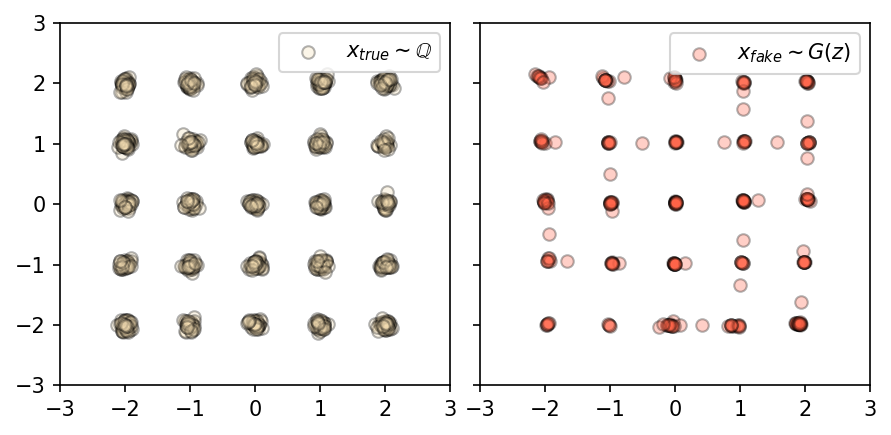

In [10]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

import torch.nn.functional as F

step_stat = {
    "generator loss": [],
    "discriminator loss": []
}

for step in range(max_steps):
    # discriminator optimization
    discriminator.train(True); generator.eval()

    for _ in range(discriminator_iters):
        x_true = th.tensor(sample_data(), device=device)
        z = th.randn_like(x_true); x_fake = generator(z)
        t = sample_time(x_true.shape[0])

        true_mixture = x_true * (1 / 2 + t / 2) + x_fake * (1 / 2 - t / 2)
        fake_mixture = x_true * (1 / 2 - t / 2) + x_fake * (1 / 2 + t / 2)

        true_disc = discriminator(t=t, x=true_mixture)
        fake_disc = discriminator(t=t, x=fake_mixture)

        loss = F.binary_cross_entropy(fake_disc, th.zeros_like(fake_disc)) + F.binary_cross_entropy(true_disc, th.ones_like(true_disc))
        
        step_stat["discriminator loss"].append(loss.item())
        discriminator_opt.zero_grad(); loss.backward(); discriminator_opt.step()

    # generator optimization
    discriminator.eval(); generator.train(True)
    
    x_true = th.tensor(sample_data(), device=device)
    z = th.randn_like(x_true); x_fake = generator(z)
    t = sample_time(x_true.shape[0])

    true_mixture = x_true * (1 / 2 + t / 2) + x_fake * (1 / 2 - t / 2)
    fake_mixture = x_true * (1 / 2 - t / 2) + x_fake * (1 / 2 + t / 2)

    true_disc = discriminator(t=t, x=true_mixture)
    fake_disc = discriminator(t=t, x=fake_mixture)

    if inverse_logs:
        loss = F.binary_cross_entropy(fake_disc, th.ones_like(fake_disc)) + F.binary_cross_entropy(true_disc, th.zeros_like(true_disc))
    else:
        loss = -F.binary_cross_entropy(fake_disc, th.zeros_like(fake_disc)) - F.binary_cross_entropy(true_disc, th.ones_like(true_disc))

    step_stat["generator loss"] = loss.item()
    generator_opt.zero_grad(); loss.backward(); generator_opt.step()

    # Plots
    discriminator.eval(); generator.eval()
        
    if step % 50 == 0:
        step_stat["generator loss"] = np.mean(step_stat["generator loss"])
        step_stat["discriminator loss"] = np.mean(step_stat["discriminator loss"])
        step_stat["step"] = step

        run.log(step_stat)

        step_stat = {
            "generator loss": [],
            "discriminator loss": []
        }

    if step % 200 == 0:
        clear_output(wait=True)
        print("Step", step)

        with th.no_grad():
            z = th.randn_like(x_true)
            x_fake = generator(z).to("cpu").numpy()

        fig, axes = plt.subplots(1, 2, figsize=(6, 3), dpi=150, sharex=True, sharey=True)

        axes[0].scatter(x_true_fixed[:, 0], x_true_fixed[:, 1], c="wheat", edgecolors="black", label=r"$x_{true} \sim \mathbb{Q}$", alpha=0.3)
        axes[1].scatter(x_fake[:, 0], x_fake[:, 1], c="tomato", edgecolors="black", label=r"$x_{fake} \sim G(z)$", alpha=0.3)
        
        axes[0].legend(loc="upper right"); axes[1].legend(loc="upper right")
        axes[0].set_xlim(-3., 3.); axes[0].set_ylim(-3., 3.)
        fig.tight_layout(); plt.show(); plt.close()

---